## 프로젝트 : 개선된 U-Net 모델 만들기

In [1]:
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

### Step 1. KITTI 데이터셋 수집과 구축

In [2]:
def build_augmentation(is_train=True):
    if is_train:
        return Compose([HorizontalFlip(p=0.5),
                        RandomSizedCrop(      
                            min_max_height=(300, 370),
                            w2h_ratio=370/1242,
                            height=224,
                            width=224,
                            p=0.5
                        ),
                        Resize(              
                            width=224,
                            height=224
                        )
                       ])
    return Compose([Resize(width=224,height=224)])

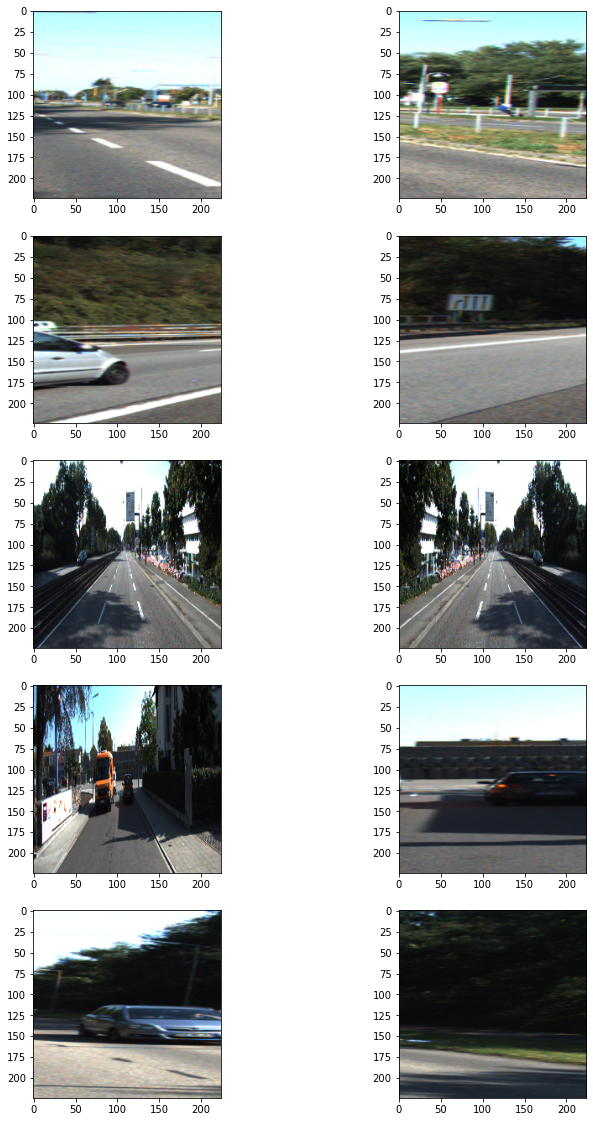

In [3]:
dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'

augmentation = build_augmentation()
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation(**image_data, is_train=False)
    processed = augmentation(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])
    
plt.show()

In [4]:
class KittiGenerator(tf.keras.utils.Sequence):
    def __init__(self, 
                 dir_path,
                 batch_size=16,
                 img_size=(224, 224, 3),
                 output_size=(224, 224),
                 is_train=True,
                 augmentation=None):

        self.dir_path = dir_path
        self.batch_size = batch_size
        self.is_train = is_train
        self.dir_path = dir_path
        self.augmentation = augmentation
        self.img_size = img_size
        self.output_size = output_size

        self.data = self.load_dataset()

    def load_dataset(self):
        input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
        label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
        input_images.sort()
        label_images.sort()
        assert len(input_images) == len(label_images)
        data = [ _ for _ in zip(input_images, label_images)]

        if self.is_train:
            return data[:-30]
        return data[-30:]
    
    def __len__(self):
        return math.ceil(len(self.data) / self.batch_size)

    def __getitem__(self, index):
        batch_data = self.data[
                               index*self.batch_size:
                               (index + 1)*self.batch_size
                               ]
        inputs = np.zeros([self.batch_size, *self.img_size])
        outputs = np.zeros([self.batch_size, *self.output_size])

        for i, data in enumerate(batch_data):
            input_img_path, output_path = data
            _input = imread(input_img_path)
            _output = imread(output_path)
            _output = (_output==7).astype(np.uint8)*1
            data = {
                "image": _input, 
                "mask": _output, 
            }
            augmented = self.augmentation(**data)
            inputs[i] = augmented["image"]/255
            outputs[i] = augmented["mask"]
        return inputs, outputs

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.data))
        if self.is_train == True :
            np.random.shuffle(self.indexes)
        return self.indexes

In [5]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

**모델 구조 만들기**

In [6]:
def build_model(input_shape=(224, 224, 3)): # 각 conv에서 padding='same' -> FC에서 centercrop 안해도 됨
    inputs = Input(input_shape)
    
    conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) # 논문에는 stride = 2. feature map size를 1/2로 만듦
    
    conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv5)

    drop5 = Dropout(0.5)(conv5)
    
    up6 = Conv2D(512, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(drop5)) 
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv6)
    
    up7 = Conv2D(256, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv7)
    
    up8 = Conv2D(128, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv8)
    
    up9 = Conv2D(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)  
    conv9 = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)     
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)
    return model

**모델 학습하기**

In [7]:
model = build_model()
model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy')
model.fit_generator(
     generator=train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
11/11 [==============================] - 35s 761ms/step - loss: 0.7925 - val_loss: 0.5871
Epoch 2/100
11/11 [==============================] - 7s 604ms/step - loss: 0.5038 - val_loss: 0.4430
Epoch 3/100
11/11 [==============================] - 7s 597ms/step - loss: 0.3925 - val_loss: 0.3998
Epoch 4/100
11/11 [==============================] - 7s 622ms/step - loss: 0.3748 - val_loss: 0.3860
Epoch 5/100
11/11 [==============================] - 8s 705ms/step - loss: 0.3264 - val_loss: 0.3898
Epoch 6/100
11/11 [==============================] - 7s 602ms/step - loss: 0.3503 - val_loss: 0.3581
Epoch 7/100
11/11 [==============================] - 7s 606ms/step - loss: 0.3219 - val_loss: 0.2962
Epoch 8/100
11/11 [==============================] - 7s 600ms/step - loss: 0.2425 - val_loss: 0.2851
Epoch 9/100
11/11 [==============================] - 7s 611ms/step - loss: 0.2423 - val_loss: 0.2670
Epoch 10/100
11/11 [==============================] - 8s 708ms/step - loss: 0.2508 - val_l

In [9]:
model_path = dir_path + '/seg_model_unet.h5'
model.save(model_path)

**모델 시각화**

In [28]:
def get_output(model, preproc, image_path, output_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()
    return output

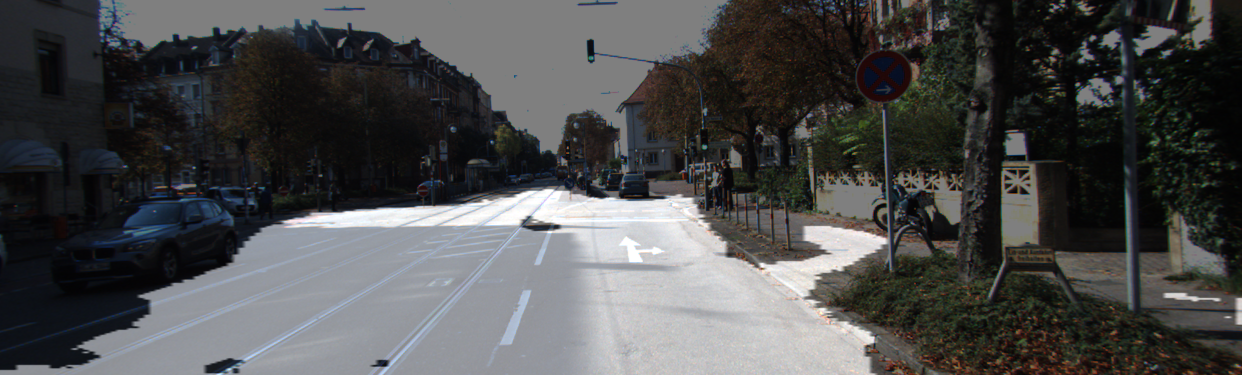

In [10]:
i = 1 
get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

In [11]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return iou_score

In [29]:
def get_output_exp(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  
    prediction = output/255
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1

        return output, prediction, target
    else:
        return output, prediction, _

In [30]:
i = 1 
output, prediction, target = get_output_exp(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.832324


0.8323236855882133

### Step 2. U-Net++ 모델의 구현

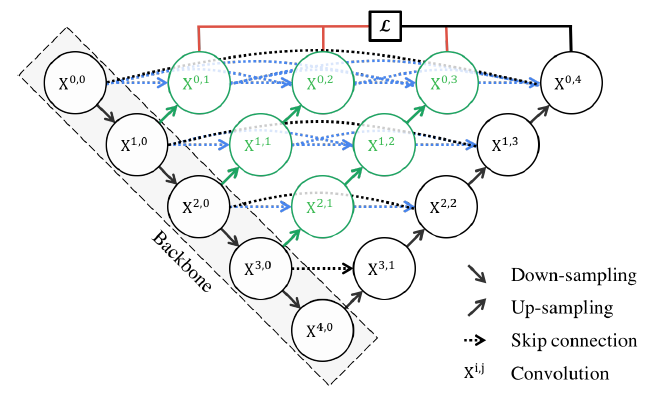
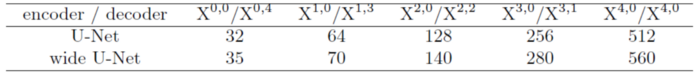   
<center> 커널 사이즈 뭐지? </center>

In [36]:
def build_unetplusplus(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)

    x00 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
    pool0 = MaxPooling2D(pool_size=(2, 2))(x00)
    
    x10 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool0)
    x01 = concatenate([x00, UpSampling2D(size=(2,2))(x10)], axis=3)
    x01 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x01)
    pool1 = MaxPooling2D(pool_size=(2, 2))(x10)
    
    x20 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1)
    x11 = concatenate([x10, UpSampling2D(size=(2,2))(x20)], axis=3)
    x11 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x11)
    x02 = concatenate([x00, x01, UpSampling2D(size=(2,2))(x11)], axis=3)
    x02 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x02)
    pool2 = MaxPooling2D(pool_size=(2, 2))(x20)
    
    x30 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool2)
    x21 = concatenate([x20, UpSampling2D(size=(2,2))(x30)], axis=3)
    x21 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x21)
    x12 = concatenate([x10, x11, UpSampling2D(size=(2,2))(x21)], axis=3)
    x12 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x12)
    x03 = concatenate([x00, x01, x02, UpSampling2D(size=(2,2))(x12)], axis=3)
    x03 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x03)
    pool3 = MaxPooling2D(pool_size=(2, 2))(x30)
    
    x40 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool3)
    
    x31 = concatenate([x30, UpSampling2D(size=(2,2))(x40)], axis=3)
    x31 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x31)
    
    x22 = concatenate([x20, x21, UpSampling2D(size=(2,2))(x31)], axis=3)
    x22 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x22)
    
    x13 = concatenate([x10, x11, x12, UpSampling2D(size=(2,2))(x22)], axis=3)
    x13 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x13)  
    
    x04 = concatenate([x00, x01, x02, x03, UpSampling2D(size=(2,2))(x13)], axis=3)
    x04 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(x04)  
    
    x = Conv2D(1, 1, activation='sigmoid')(x04)

    # deep supervision
    output_1 = Conv2D(1, 1, activation='sigmoid')(x01)
    output_2 = Conv2D(1, 1, activation='sigmoid')(x02)
    output_3 = Conv2D(1, 1, activation='sigmoid')(x03)
    output_4 = Conv2D(1, 1, activation='sigmoid')(x04)

    outputs = average([output_1, output_2, output_3, output_4])
    ensemble_model = Model(inputs=inputs, outputs=outputs)

    return ensemble_model

**모델 학습하기**

In [23]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path,
    batch_size=4,
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    batch_size=4,
    augmentation=test_preproc,
    is_train=False
)

In [38]:
model_upp = build_unetplusplus()
model_upp.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy')
history = model_upp.fit_generator(
     generator=train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

Epoch 1/100
43/43 [==============================] - 15s 332ms/step - loss: 0.5068 - val_loss: 0.5107
Epoch 2/100
43/43 [==============================] - 14s 324ms/step - loss: 0.3662 - val_loss: 0.3878
Epoch 3/100
43/43 [==============================] - 13s 308ms/step - loss: 0.3189 - val_loss: 0.3269
Epoch 4/100
43/43 [==============================] - 13s 310ms/step - loss: 0.3038 - val_loss: 0.3430
Epoch 5/100
43/43 [==============================] - 13s 310ms/step - loss: 0.2946 - val_loss: 0.3367
Epoch 6/100
43/43 [==============================] - 13s 311ms/step - loss: 0.2630 - val_loss: 0.3326
Epoch 7/100
43/43 [==============================] - 13s 312ms/step - loss: 0.2548 - val_loss: 0.3772
Epoch 8/100
43/43 [==============================] - 13s 312ms/step - loss: 0.2625 - val_loss: 0.3003
Epoch 9/100
43/43 [==============================] - 13s 313ms/step - loss: 0.2473 - val_loss: 0.2678
Epoch 10/100
43/43 [==============================] - 14s 313ms/step - loss: 0.263

**모델 시각화**

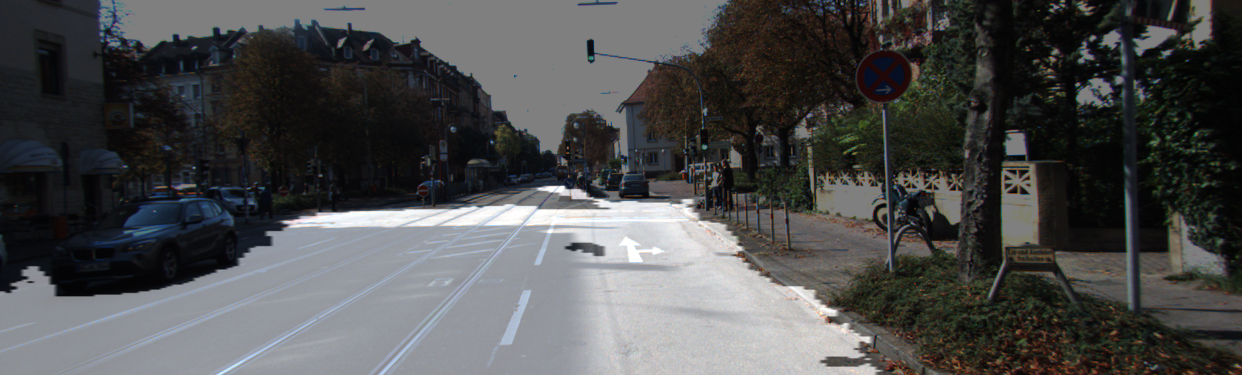

In [39]:
i = 1 
get_output(
     model_upp, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

In [41]:
i = 1 
output, prediction, target = get_output_exp(
     model_upp, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.918806


0.9188060624806681

### Step 3. U-Net 과 U-Net++ 모델이 수행한 세그멘테이션 결과 분석

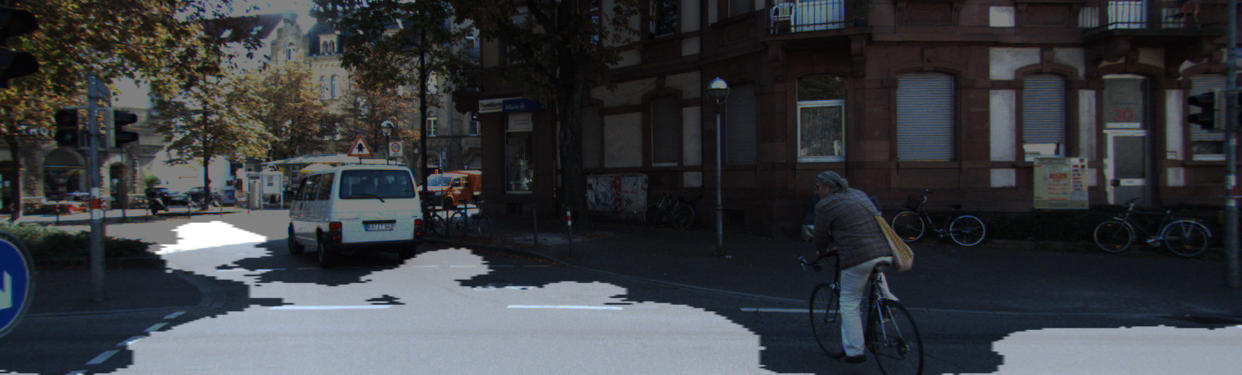

In [44]:
get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(2).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(2).zfill(3)}.png'
 )

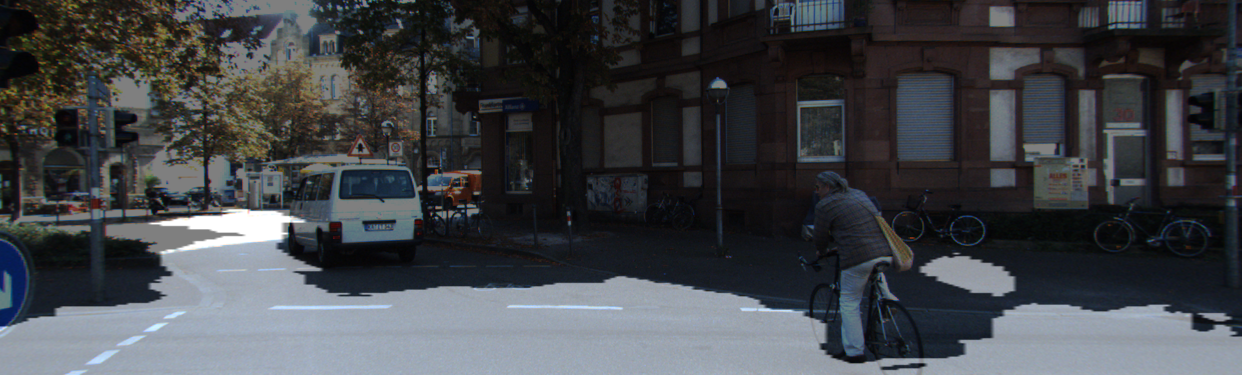

In [45]:
get_output(
     model_upp, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(2).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(2).zfill(3)}.png'
 )

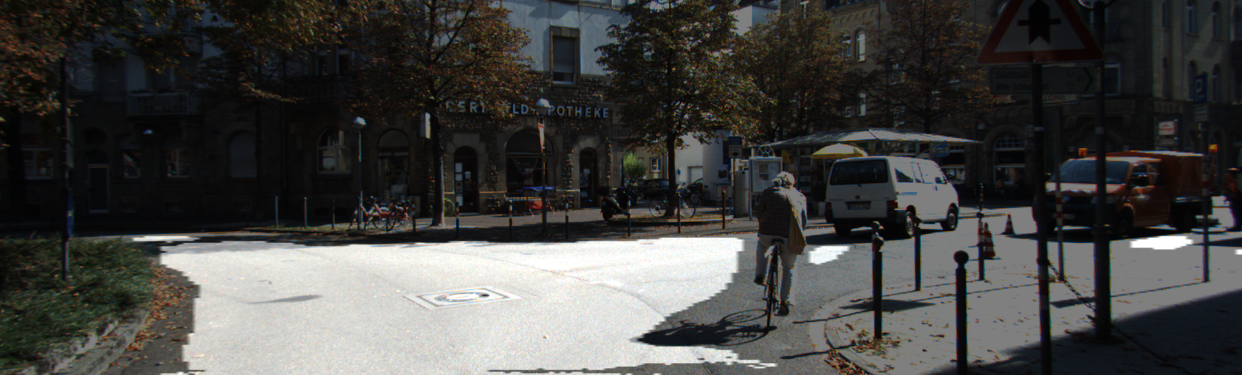

In [46]:
get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(3).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(3).zfill(3)}.png'
 )

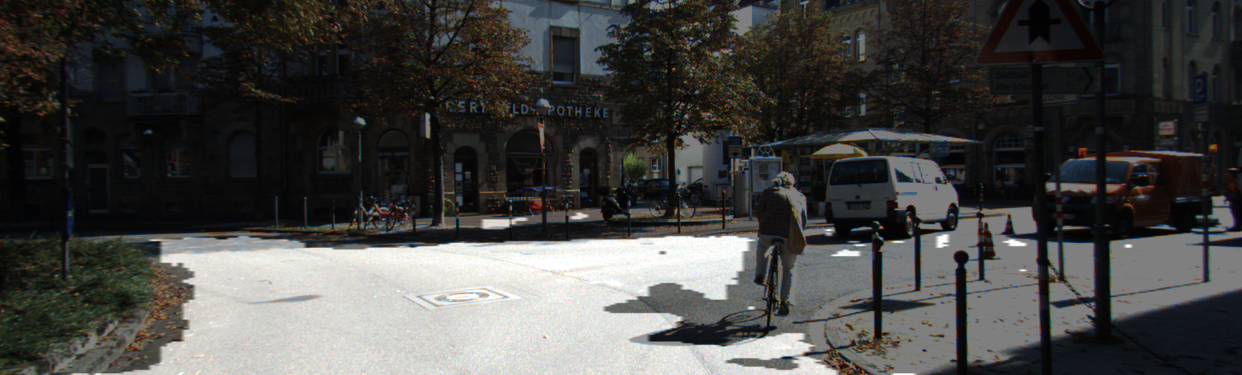

In [47]:
get_output(
     model_upp, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(3).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(3).zfill(3)}.png'
 )

**3장의 사진을 비교해봤을 때, 확실히 UNet++가 더 정확하게 Segmentation을 수행했음을 알 수 있다. (model이 일반 UNet, model_upp가 UNet++)**

In [51]:
iou = 0
for i in range(10):
    output, prediction, target = get_output_exp(
         model, 
         test_preproc,
         image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
         output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
         label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
     )

    iou += calculate_iou_score(target, prediction)
print(iou/10)

IoU : 0.578481
IoU : 0.832324
IoU : 0.617702
IoU : 0.664931
IoU : 0.799502
IoU : 0.822619
IoU : 0.896063
IoU : 0.695528
IoU : 0.723450
IoU : 0.527763
0.7158363427112533


In [52]:
iou = 0
for i in range(10):
    output, prediction, target = get_output_exp(
         model_upp, 
         test_preproc,
         image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
         output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
         label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
     )

    iou += calculate_iou_score(target, prediction)
print(iou/10)

IoU : 0.845040
IoU : 0.918806
IoU : 0.766858
IoU : 0.707512
IoU : 0.831094
IoU : 0.791212
IoU : 0.862780
IoU : 0.933606
IoU : 0.868212
IoU : 0.826777
0.8351896301939552


**i=0부터 i=9까지의 이미지들을 대상으로 UNet, UNet++에 대해 IoU값의 평균을 계산했을 때도, UNet++가 0.1 이상 더 높은 점수를 내놨다.**

### 회고

1. UNet++는 이미지만 봐도 모든 $X^{i,j}$들을 저장해놔야 하기 때문에 메모리를 많이 필요로 할 것 같다.   
2. 이번 노드는 논문과 노드의 UNet 구현에 다른 점이 좀 있었다.
    - padding 적용 여부 + centercrop 적용 여부
    - maxpooling layer에서 stride=2 적용 여부
    - loss function 종류   
3. 요즘 시간이 부족해서 제출일에 급하게 하느라 꼬이면 안돼서, UNet에는 적용된 dropout 등을 UNet++에는 적용하지 않았는데, UNet++가 훈련할 때 loss와 val_loss를 보면 dropout을 적용할 때 조금 더 성능이 향상될 것 같다는 생각이 든다.